# 대출 이자 계산 알고리즘

## 용어표
- Principal: 원금
- Interest: 이자
- Interest Rate: 이자율

## 대출 상환 스케줄

### 원리금 균등상환
- 영문 표기: Amortized Loan | Equal payment Loan
- 상환 방식: 매달 동일한 금액을 원리금(원금 + 이자)으로 상환하는 방식
- 특징: 상환스케줄 초반에는 상환원금이 적고, 후반으로 갈수록 상환원금이 증가하는 구조
- 월할 이자 계산: 이자 계산시, 월별 일수 변동(28일, 30일, 31일)을 고려하지 않음

$$
M = P \times \frac{r(1 + r)^n}{(1 + r)^n - 1}
$$

- $M$ = 매월 상환금액
- $P$ = 대출 원금
- $r$ = 월 이자율 (연이자율 / 12)
- $n$ = 총 상환 횟수 (대출 기간 * 12)

### 원금 균등상환
- 영문 표기: Equal principal payment Loan
- 상환 방식: 매월 일정한 원금(대출금액을 대출기간으로 나눈값)을 상환하는 방식
- 특징: 상환 회차별 상환원금이 일정하나, 원리금은 상환 회차마다 상이함 / 원리금균등 상환방식보다 원금상환 속도가 빠르기 때문에 총 이자납입액이 적음
- 월별 이자 계산시, 통상 월별 일수(30일, 31일) 변동을 고려함
- 계산식: 대출잔액(회차별) * 연이자율 * (사용일수/365)

$$
M_t = \frac{P}{n} + \left(P - \frac{P(t-1)}{n}\right) \times r
$$

- $M_t$ = t번째 달의 상환금액
- $P$ = 대출 원금
- $r$ = 월 이자율 (연이자율 / 12)
- $n$ = 총 상환 횟수 (대출 기간 * 12)
- $t$ = 현재 상환 회차

### 만기일시상환
- 영문 표기: Interest-Only Loan
- 상환 방식: 대출만기까지 이자만 상환하고 원금은 만기시점에 일시에 갚는 방식
- 특징: 월별이자 계산시, 월별 일수(30일, 31일) 변동을 고려함
- 계산식: 대출잔액 * 연이자율 * (사용일수/365)

$$
I = P \times r \times n
$$

$$
F = P + I
$$

- $I$ = 총 이자액
- $P$ = 대출 원금
- $r$ = 월 이자율 (연이자율 / 12)
- $n$ = 총 상환 횟수 (대출 기간 * 12)
- $F$ = 만기일에 상환할 총 금액 (원금 + 이자)

## Function

In [1]:
import matplotlib.pyplot as plt

def graph_function(df):
    _, ax = plt.subplots(figsize=(10, 6))

    df[:-1][['Principal', 'Interest']].plot(kind='bar', stacked=True, ax=ax)

    ax.set_title('Principal and Interest Payments Over Time')
    ax.set_xlabel('Period')
    ax.set_ylabel('Amount')
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df['Payment Date'], rotation=45, ha='right')

    plt.legend(['Principal', 'Interest'])
    plt.tight_layout()

    plt.show()

## 원리금균등분할상환 알고리즘

In [2]:
import math
from datetime import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd

def calculate_equal_payment(
        start_date: datetime,
        principal: int,
        expiration_months: int,
        annual_interest_rate: str = 0.28,
        cycle: str = ['month', '4week', '2week', 'week']
    ) -> pd.DataFrame:
    
    total_period = 0
    cycle_cnt = 0

    expire_date = start_date + relativedelta(months=expiration_months)
    total_days = (expire_date - start_date).days

    if cycle == 'month':
        cycle_cnt = 12
        total_period = expiration_months
    elif cycle == '4week':
        cycle_cnt = 13
        total_period = math.ceil(total_days / 28)
    elif cycle == '2week':
        cycle_cnt = 26
        total_period = math.ceil(total_days / 14)
    elif cycle == 'week':
        cycle_cnt = 52
        total_period = math.ceil(total_days / 7)

    period_interest_rate = ((1 + annual_interest_rate / cycle_cnt) ** total_period) - 1
    amount_per_period = round((principal*annual_interest_rate/cycle_cnt * (1+annual_interest_rate/cycle_cnt) ** total_period) / period_interest_rate)

    schedule = []
    current_date = start_date

    total_principal_payment = 0
    total_interest_payment = 0
    total_principal_n_interest = 0
    
    for period in range(1, total_period+1):
        interest_payment = round(principal * annual_interest_rate / cycle_cnt)
        principal_payment = round(amount_per_period - interest_payment)
        principal -= principal_payment

        total_principal_payment += principal_payment
        total_interest_payment += interest_payment
        total_principal_n_interest += amount_per_period
        
        current_date += relativedelta(months=1) if cycle == 'month' else relativedelta(weeks=int(cycle[:-4]) if 'week' in cycle else 1)

        schedule.append({
            'Period': period,
            'Payment Date': current_date.strftime('%Y-%m-%d (%A)'),
            'Principal': principal_payment,
            'Interest': interest_payment,
            'Total': amount_per_period,
            'Remaining Balance': round(principal),
        })

    schedule.append({
        'Period': 'Total',
        'Payment Date': '-',
        'Principal': total_principal_payment,
        'Interest': total_interest_payment,
        'Total': total_principal_n_interest,
        'Remaining Balance': '-',
    })

    df = pd.DataFrame(schedule)
    # df = df.style.hide(axis='index')
    return df

### 예제

In [3]:
from datetime import datetime
start_date = datetime(2024, 7, 17)
principal = 1000000
expiration_months = 24
annual_interest_rate = 0.28

In [4]:
# 한달 단위
df = calculate_equal_payment(start_date, principal, expiration_months, annual_interest_rate, cycle='month')

# 4주 단위
# df = calculate_equal_payment(start_date, principal, expiration_months, annual_interest_rate, cycle='4week')

# 2주 단위
# df = calculate_equal_payment(start_date, principal, expiration_months, annual_interest_rate, cycle='2week')

# 1주 단위
# df = calculate_equal_payment(start_date, principal, expiration_months, annual_interest_rate, cycle='week')

df

,Period,Payment Date,Principal,Interest,Total,Remaining Balance
0,1,2024-08-17 (Saturday),31555,23333,54888,968445
1,2,2024-09-17 (Tuesday),32291,22597,54888,936154
2,3,2024-10-17 (Thursday),33044,21844,54888,903110
3,4,2024-11-17 (Sunday),33815,21073,54888,869295
4,5,2024-12-17 (Tuesday),34604,20284,54888,834691
5,6,2025-01-17 (Friday),35412,19476,54888,799279
6,7,2025-02-17 (Monday),36238,18650,54888,763041
7,8,2025-03-17 (Monday),37084,17804,54888,725957
8,9,2025-04-17 (Thursday),37949,16939,54888,688008
9,10,2025-05-17 (Saturday),38834,16054,54888,649174


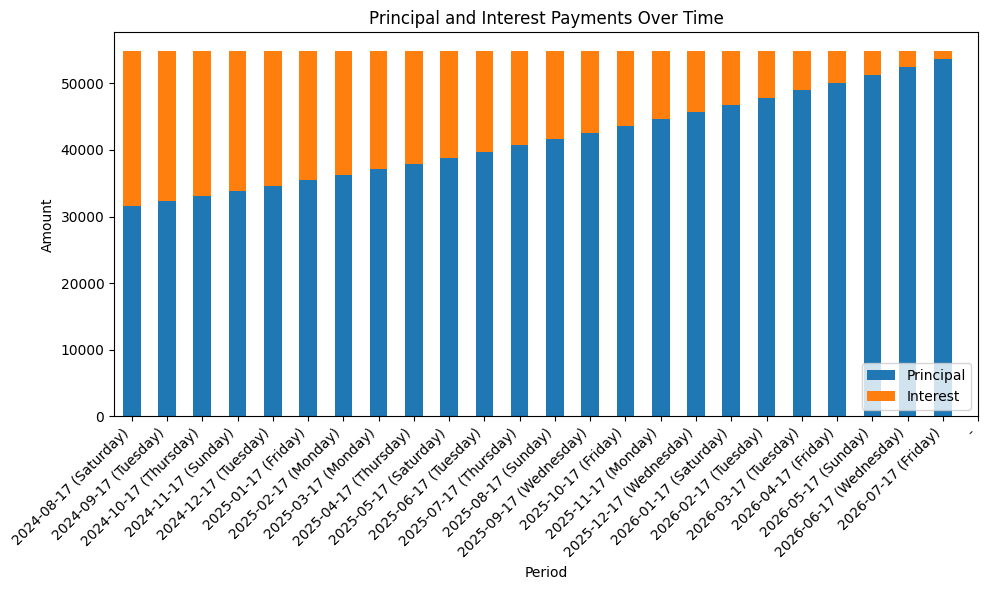

In [5]:
graph_function(df)

## 원금균등분할상환 알고리즘

In [6]:
import math
from datetime import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd

def calculate_equal_principal_payment(
        start_date: datetime,
        principal: int,
        expiration_months: int,
        annual_interest_rate: str = 0.28,
        cycle: str = ['month', '4week', '2week', 'week']
    ) -> pd.DataFrame:
    
    total_period = 0
    cycle_cnt = 0

    expire_date = start_date + relativedelta(months=expiration_months)
    total_days = (expire_date - start_date).days

    if cycle == 'month':
        cycle_cnt = 12
        total_period = expiration_months
    elif cycle == '4week':
        cycle_cnt = 13
        total_period = math.ceil(total_days / 28)
    elif cycle == '2week':
        cycle_cnt = 26
        total_period = math.ceil(total_days / 14)
    elif cycle == 'week':
        cycle_cnt = 52
        total_period = math.ceil(total_days / 7)

    period_interest_rate = annual_interest_rate / cycle_cnt

    schedule = []
    current_date = start_date

    total_principal_payment = 0
    total_interest_payment = 0
    total_principal_n_interest = 0
    
    principal_payment = round(principal / total_period)
    for period in range(1, total_period+1):
        interest_payment = round(principal * period_interest_rate)
        amount_per_period = principal_payment + interest_payment
        principal -= principal_payment

        total_principal_payment += principal_payment
        total_interest_payment += interest_payment
        total_principal_n_interest += amount_per_period
        
        current_date += relativedelta(months=1) if cycle == 'month' else relativedelta(weeks=int(cycle[:-4]) if 'week' in cycle else 1)

        schedule.append({
            'Period': period,
            'Payment Date': current_date.strftime('%Y-%m-%d (%A)'),
            'Principal': principal_payment,
            'Interest': interest_payment,
            'Total': amount_per_period,
            'Remaining Balance': round(principal),
        })

    schedule.append({
        'Period': 'Total',
        'Payment Date': '-',
        'Principal': total_principal_payment,
        'Interest': total_interest_payment,
        'Total': total_principal_n_interest,
        'Remaining Balance': '-',
    })

    df = pd.DataFrame(schedule)
    # df = df.style.hide(axis='index')
    return df

### 예제

In [7]:
from datetime import datetime
start_date = datetime(2024, 7, 17)
principal = 1000000
expiration_months = 24
annual_interest_rate = 0.28

In [8]:
# 한달 단위
df = calculate_equal_principal_payment(start_date, principal, expiration_months, annual_interest_rate, cycle='month')

# 4주 단위
# df = calculate_equal_principal_payment(start_date, principal, expiration_months, annual_interest_rate, cycle='4week')

# 2주 단위
# df = calculate_equal_principal_payment(start_date, principal, expiration_months, annual_interest_rate, cycle='2week')

# 1주 단위
# df = calculate_equal_principal_payment(start_date, principal, expiration_months, annual_interest_rate, cycle='week')

df

,Period,Payment Date,Principal,Interest,Total,Remaining Balance
0,1,2024-08-17 (Saturday),41667,23333,65000,958333
1,2,2024-09-17 (Tuesday),41667,22361,64028,916666
2,3,2024-10-17 (Thursday),41667,21389,63056,874999
3,4,2024-11-17 (Sunday),41667,20417,62084,833332
4,5,2024-12-17 (Tuesday),41667,19444,61111,791665
5,6,2025-01-17 (Friday),41667,18472,60139,749998
6,7,2025-02-17 (Monday),41667,17500,59167,708331
7,8,2025-03-17 (Monday),41667,16528,58195,666664
8,9,2025-04-17 (Thursday),41667,15555,57222,624997
9,10,2025-05-17 (Saturday),41667,14583,56250,583330


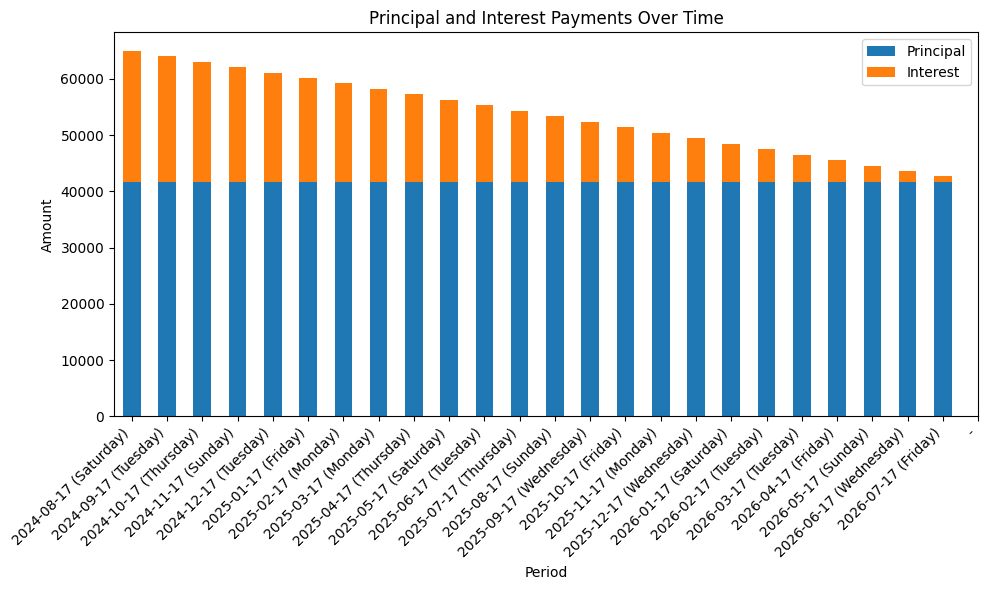

In [9]:
graph_function(df)

## 만기일시상환 알고리즘

In [10]:
import math
from datetime import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd

def calculate_bullet_payment(
        start_date: datetime,
        principal: int,
        expiration_months: int,
        annual_interest_rate: str = 0.28,
        cycle: str = ['month', '4week', '2week', 'week']
    ) -> pd.DataFrame:
    
    total_period = 0
    cycle_cnt = 0

    expire_date = start_date + relativedelta(months=expiration_months)
    total_days = (expire_date - start_date).days

    if cycle == 'month':
        cycle_cnt = 12
        total_period = expiration_months
    elif cycle == '4week':
        cycle_cnt = 13
        total_period = math.ceil(total_days / 28)
    elif cycle == '2week':
        cycle_cnt = 26
        total_period = math.ceil(total_days / 14)
    elif cycle == 'week':
        cycle_cnt = 52
        total_period = math.ceil(total_days / 7)

    period_interest_rate = annual_interest_rate / cycle_cnt

    schedule = []
    current_date = start_date

    total_principal_payment = 0
    total_interest_payment = 0
    total_principal_n_interest = 0
    
    for period in range(1, total_period+1):
        interest_payment = round(principal * period_interest_rate)
        amount_per_period = interest_payment

        total_interest_payment += interest_payment
        total_principal_n_interest += amount_per_period

        current_date += relativedelta(months=1) if cycle == 'month' else relativedelta(weeks=int(cycle[:-4]) if 'week' in cycle else 1)

        schedule.append({
            'Period': period,
            'Payment Date': current_date.strftime('%Y-%m-%d (%A)'),
            'Principal': 0,
            'Interest': interest_payment,
            'Total': amount_per_period,
            'Remaining Balance': round(principal),
        })

    total_principal_payment = principal
    schedule.append({
        'Period': 'Total',
        'Payment Date': '-',
        'Principal': total_principal_payment,
        'Interest': total_interest_payment,
        'Total': total_principal_n_interest + principal,
        'Remaining Balance': '-',
    })

    df = pd.DataFrame(schedule)
    # df = df.style.hide(axis='index')
    return df

### 예제

In [11]:
from datetime import datetime
start_date = datetime(2024, 7, 17)
cycles = ['month', '4week', '2week', 'week']
principal = 1000000
expiration_months = 24
annual_interest_rate = 0.28

In [12]:
# 한달 단위
df = calculate_bullet_payment(start_date, principal, expiration_months, annual_interest_rate, cycle='month')

# 4주 단위
# df = calculate_bullet_payment(start_date, principal, expiration_months, annual_interest_rate, cycle='4week')

# 2주 단위
# df = calculate_bullet_payment(start_date, principal, expiration_months, annual_interest_rate, cycle='2week')

# 1주 단위
# df = calculate_bullet_payment(start_date, principal, expiration_months, annual_interest_rate, cycle='week')

df

,Period,Payment Date,Principal,Interest,Total,Remaining Balance
0,1,2024-08-17 (Saturday),0,23333,23333,1000000
1,2,2024-09-17 (Tuesday),0,23333,23333,1000000
2,3,2024-10-17 (Thursday),0,23333,23333,1000000
3,4,2024-11-17 (Sunday),0,23333,23333,1000000
4,5,2024-12-17 (Tuesday),0,23333,23333,1000000
5,6,2025-01-17 (Friday),0,23333,23333,1000000
6,7,2025-02-17 (Monday),0,23333,23333,1000000
7,8,2025-03-17 (Monday),0,23333,23333,1000000
8,9,2025-04-17 (Thursday),0,23333,23333,1000000
9,10,2025-05-17 (Saturday),0,23333,23333,1000000


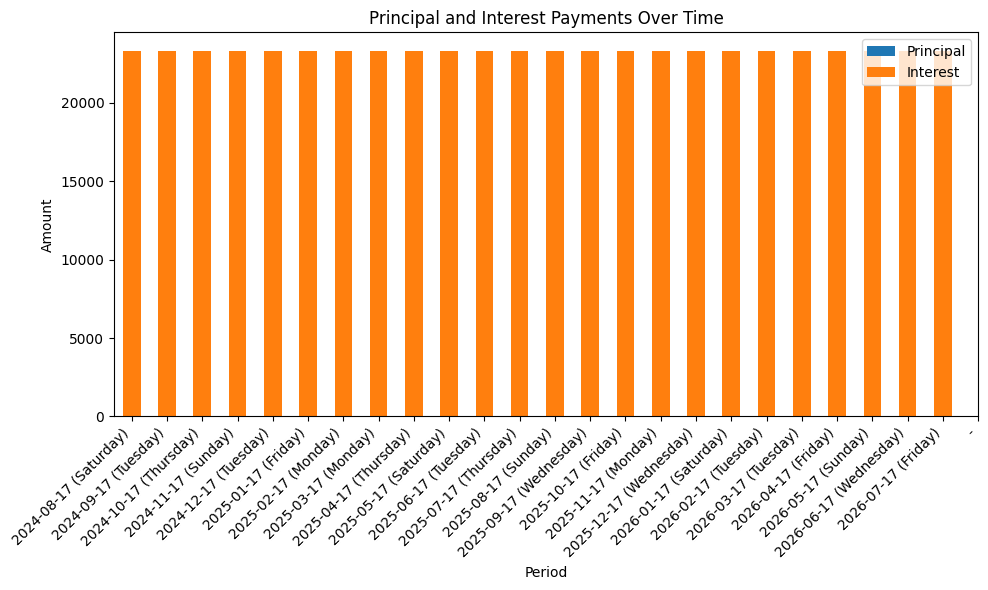

In [13]:
graph_function(df)

## 연체

### 연체 계산 방식

$$
D = A \times \frac{d \times r_d}{365}
$$

- $D$ = 연체이자
- $A$ = 연체된 금액
- $d$ = 연체 일수
- $r_d$ = 연체이자율

In [14]:
def calculate_overdue_interest(principal, annual_interest_rate, loan_period_years, overdue_days, overdue_interest_rate):
    loan_period_months = loan_period_years * 12

    monthly_interest_rate = annual_interest_rate / 12

    monthly_payment = principal * (monthly_interest_rate * (1 + monthly_interest_rate) ** loan_period_months) / ((1 + monthly_interest_rate) ** loan_period_months - 1)

    overdue_amount = monthly_payment

    overdue_interest = overdue_amount * (overdue_days * overdue_interest_rate / 365)

    return overdue_interest

In [15]:
principal = 10000000
annual_interest_rate = 0.05
loan_period_years = 5
overdue_days = 10
overdue_interest_rate = 0.12
month = 1

overdue_interest = calculate_overdue_interest(principal, annual_interest_rate, loan_period_years, overdue_days, overdue_interest_rate)
print(f"연체 이자: {overdue_interest}원")

연체 이자: 620.4241198031009원


# 클래스화

In [16]:
import math
from datetime import datetime
from dateutil.relativedelta import relativedelta
from typing import Tuple

import pandas as pd

class LoanCalculator:
    
    def __init__(self, start_date: datetime, principal: int, expiration_months: int, annual_interest_rate: float=0.28):
        self.start_date = start_date
        self.principal = principal
        self.expiration_months = expiration_months
        self.annual_interest_rate = annual_interest_rate
        self.expire_date = start_date + relativedelta(months=expiration_months)
        self.total_days = (self.expire_date - start_date).days
        
    def _get_schedule_details(self, cycle: str) -> Tuple[int, int]:
        if cycle == 'month':
            cycle_cnt = 12
            total_period = self.expiration_months
        elif cycle == '4week':
            cycle_cnt = 13
            total_period = math.ceil(self.total_days / 28)
        elif cycle == '2week':
            cycle_cnt = 26
            total_period = math.ceil(self.total_days / 14)
        elif cycle == 'week':
            cycle_cnt = 52
            total_period = math.ceil(self.total_days / 7)
        return cycle_cnt, total_period
    
    def equal_payment(self, cycle: str='month') -> pd.DataFrame:
        cycle_cnt, total_period = self._get_schedule_details(cycle)
        period_interest_rate = ((1 + self.annual_interest_rate / cycle_cnt) ** total_period) - 1
        amount_per_period = round((self.principal * self.annual_interest_rate / cycle_cnt * (1 + self.annual_interest_rate / cycle_cnt) ** total_period) / period_interest_rate)
        
        schedule = []
        current_date = self.start_date
        principal = self.principal
        total_principal_payment = total_interest_payment = total_principal_n_interest = 0

        current_date += relativedelta(months=1) if cycle == 'month' else relativedelta(weeks=int(cycle[:-4]) if 'week' in cycle else 1)
        
        for period in range(1, total_period + 1):
            interest_payment = round(principal * self.annual_interest_rate / cycle_cnt)
            principal_payment = round(amount_per_period - interest_payment)
            principal -= principal_payment

            total_principal_payment += principal_payment
            total_interest_payment += interest_payment
            total_principal_n_interest += amount_per_period

            schedule.append({
                'Period': period,
                'Payment Date': current_date.strftime('%Y-%m-%d (%A)'),
                'Principal': principal_payment,
                'Interest': interest_payment,
                'Total': amount_per_period,
                'Remaining Balance': round(principal),
            })

        schedule.append({
            'Period': 'Total',
            'Payment Date': '-',
            'Principal': total_principal_payment,
            'Interest': total_interest_payment,
            'Total': total_principal_n_interest,
            'Remaining Balance': '-',
        })
        
        return pd.DataFrame(schedule)
    
    def equal_principal_payment(self, cycle: str='month') -> pd.DataFrame:
        cycle_cnt, total_period = self._get_schedule_details(cycle)
        period_interest_rate = self.annual_interest_rate / cycle_cnt
        
        schedule = []
        current_date = self.start_date
        principal = self.principal
        principal_payment = round(principal / total_period)
        total_principal_payment = total_interest_payment = total_principal_n_interest = 0
        
        for period in range(1, total_period + 1):
            interest_payment = round(principal * period_interest_rate)
            amount_per_period = principal_payment + interest_payment
            principal -= principal_payment

            total_principal_payment += principal_payment
            total_interest_payment += interest_payment
            total_principal_n_interest += amount_per_period
            
            current_date += relativedelta(months=1) if cycle == 'month' else relativedelta(weeks=int(cycle[:-4]) if 'week' in cycle else 1)

            schedule.append({
                'Period': period,
                'Payment Date': current_date.strftime('%Y-%m-%d (%A)'),
                'Principal': principal_payment,
                'Interest': interest_payment,
                'Total': amount_per_period,
                'Remaining Balance': round(principal),
            })
        
        schedule.append({
            'Period': 'Total',
            'Payment Date': '-',
            'Principal': total_principal_payment,
            'Interest': total_interest_payment,
            'Total': total_principal_n_interest,
            'Remaining Balance': '-',
        })
        
        return pd.DataFrame(schedule)
    
    def bullet_payment(self, cycle: str='month') -> pd.DataFrame:
        cycle_cnt, total_period = self._get_schedule_details(cycle)
        period_interest_rate = self.annual_interest_rate / cycle_cnt
        
        schedule = []
        current_date = self.start_date
        principal = self.principal
        total_interest_payment = total_principal_n_interest = 0
        
        for period in range(1, total_period + 1):
            interest_payment = round(principal * period_interest_rate)
            total_interest_payment += interest_payment
            total_principal_n_interest += interest_payment
            
            current_date += relativedelta(months=1) if cycle == 'month' else relativedelta(weeks=int(cycle[:-4]) if 'week' in cycle else 1)

            schedule.append({
                'Period': period,
                'Payment Date': current_date.strftime('%Y-%m-%d (%A)'),
                'Principal': 0,
                'Interest': interest_payment,
                'Total': interest_payment,
                'Remaining Balance': round(principal),
            })
        
        total_principal_payment = principal
        schedule.append({
            'Period': 'Total',
            'Payment Date': '-',
            'Principal': total_principal_payment,
            'Interest': total_interest_payment,
            'Total': total_principal_n_interest + principal,
            'Remaining Balance': '-',
        })
        
        return pd.DataFrame(schedule)
    
    def overdue_interest(self, loan_period_years: int, overdue_days: int, overdue_interest_rate: float) -> int:
        loan_period_months = loan_period_years * 12
        monthly_interest_rate = self.annual_interest_rate / 12
        monthly_payment = self.principal * (monthly_interest_rate * (1 + monthly_interest_rate) ** loan_period_months) / ((1 + monthly_interest_rate) ** loan_period_months - 1)
        overdue_amount = monthly_payment
        overdue_interest = overdue_amount * (overdue_days * overdue_interest_rate / 365)
        
        return overdue_interest

# 알고리즘 수정 (업데이트)

In [17]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd

class LoanCalculator:
    
    def __init__(self, start_date: datetime, principal: int, num_payments: int, cycle_days: int, annual_interest_rate: float = 0.28):
        self.start_date = start_date
        self.principal = principal
        self.num_payments = num_payments
        self.annual_interest_rate = annual_interest_rate
        self.cycle_days = cycle_days
        self.total_days = self.cycle_days * num_payments
        self.expire_date = start_date + relativedelta(days=self.total_days)

    def equal_payment(self) -> pd.DataFrame:
        period_interest_rate = self.annual_interest_rate / 12
        amount_per_period = self.principal * period_interest_rate * (1 + period_interest_rate) ** self.num_payments / ((1 + period_interest_rate) ** self.num_payments - 1)
        amount_per_period = round(amount_per_period)
        
        schedule = []
        current_date = self.start_date
        principal = self.principal

        for period in range(1, self.num_payments + 1):
            interest_payment = round(principal * period_interest_rate)
            principal_payment = round(amount_per_period - interest_payment)
            
            if period == self.num_payments:
                principal_payment = principal
                amount_per_period = principal_payment + interest_payment
                
            principal -= principal_payment

            current_date += relativedelta(days=self.cycle_days)

            schedule.append({
                'Period': period,
                'Payment Date': current_date.strftime('%Y-%m-%d'),
                'Principal': principal_payment,
                'Interest': interest_payment,
                'Total': amount_per_period,
                'Remaining Balance': round(principal),
            })
        
        return pd.DataFrame(schedule)
    
    def equal_principal_payment(self) -> pd.DataFrame:
        principal_payment = round(self.principal / self.num_payments)
        period_interest_rate = self.annual_interest_rate / 12
        
        schedule = []
        current_date = self.start_date
        principal = self.principal
        
        for period in range(1, self.num_payments + 1):
            interest_payment = round(principal * period_interest_rate)
            amount_per_period = principal_payment + interest_payment
            
            if period == self.num_payments:
                principal_payment = principal
                amount_per_period = principal_payment + interest_payment
            
            principal -= principal_payment
            
            current_date += relativedelta(days=self.cycle_days)

            schedule.append({
                'Period': period,
                'Payment Date': current_date.strftime('%Y-%m-%d'),
                'Principal': principal_payment,
                'Interest': interest_payment,
                'Total': amount_per_period,
                'Remaining Balance': round(principal),
            })
        
        return pd.DataFrame(schedule)
    
    def bullet_payment(self) -> pd.DataFrame:
        period_interest_rate = self.annual_interest_rate / 12
        
        schedule = []
        current_date = self.start_date
        principal = self.principal
        
        for period in range(1, self.num_payments + 1):
            interest_payment = round(principal * period_interest_rate)
            
            current_date += relativedelta(days=self.cycle_days)

            if period == self.num_payments:
                total_payment = principal + interest_payment
                principal_payment = principal
                principal = 0
            else:
                total_payment = interest_payment
                principal_payment = 0

            schedule.append({
                'Period': period,
                'Payment Date': current_date.strftime('%Y-%m-%d'),
                'Principal': principal_payment,
                'Interest': interest_payment,
                'Total': total_payment,
                'Remaining Balance': round(principal),
            })
        
        return pd.DataFrame(schedule)
    
    def overdue_interest(self, amount: int, overdue_days: int, overdue_interest_rate: float) -> int:
        overdue_interest = amount * (overdue_interest_rate / 365 * overdue_days)

        return overdue_interest


In [18]:
from datetime import datetime

start_date = datetime(2024, 9, 1)
principal = 100000000
num_payments = 26
annual_interest_rate = 0.28
cycle_days = 14

loan_calculator = LoanCalculator(start_date, principal, num_payments, cycle_days, annual_interest_rate)

equal_payment_schedule_df = loan_calculator.equal_payment()
print("Equal Payment Schedule:")
print(equal_payment_schedule_df)

equal_principal_payment_schedule_df = loan_calculator.equal_principal_payment()
print("\nEqual Principal Payment Schedule:")
print(equal_principal_payment_schedule_df)

bullet_payment_schedule_df = loan_calculator.bullet_payment()
print("\nBullet Payment Schedule:")
print(bullet_payment_schedule_df)

Equal Payment Schedule:
    Period Payment Date  Principal  Interest    Total  Remaining Balance
0        1   2024-09-15    2840102   2333333  5173435           97159898
1        2   2024-09-29    2906371   2267064  5173435           94253527
2        3   2024-10-13    2974186   2199249  5173435           91279341
3        4   2024-10-27    3043584   2129851  5173435           88235757
4        5   2024-11-10    3114601   2058834  5173435           85121156
5        6   2024-11-24    3187275   1986160  5173435           81933881
6        7   2024-12-08    3261644   1911791  5173435           78672237
7        8   2024-12-22    3337749   1835686  5173435           75334488
8        9   2025-01-05    3415630   1757805  5173435           71918858
9       10   2025-01-19    3495328   1678107  5173435           68423530
10      11   2025-02-02    3576886   1596549  5173435           64846644
11      12   2025-02-16    3660347   1513088  5173435           61186297
12      13   2025-03-02    